# 第7章: 機械学習

本章では、[Stanford Sentiment Treebank (SST)](https://nlp.stanford.edu/sentiment/) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、[General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/) ベンチマークで配布されているSSTデータセットを用いる。


In [8]:
import pandas as pd
train = pd.read_csv("../data/ch07/SST-2/train.tsv", sep="\t")

train.head(10)

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
5,that 's far too tragic to merit such superfici...,0
6,demonstrates that the director of such hollywo...,1
7,of saucy,1
8,a depressed fifteen-year-old 's suicidal poetry,0
9,are more deeply thought through than in most `...,1


## 60. データの入手・整形

GLUEのウェブサイトから[SST-2](https://dl.fbaipublicfiles.com/glue/data/SST-2.zip)データセットを取得せよ。学習データ（`train.tsv`）と検証データ（`dev.tsv`）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [76]:
%%capture cap
import pandas as pd

train = pd.read_csv("../data/ch07/SST-2/train.tsv", sep="\t")
dev = pd.read_csv("../data/ch07/SST-2/dev.tsv", sep="\t")

train_positive = len(train[train["label"] == 1])
train_negative = len(train[train["label"] == 0])

dev_positive = len(dev[dev["label"] == 1])
dev_negative = len(dev[dev["label"] == 0])

print(f"train positive {train_positive} : train negative {train_negative}")
print(f"dev positive {dev_positive} : dev negative {dev_negative}")

In [77]:
with open('../outputs/ch07/result60.txt', 'w') as f:
    f.write(cap.stdout)
print(cap)

train positive 37569 : train negative 29780
dev positive 444 : dev negative 428



## 61. 特徴ベクトル

Bag of Words (BoW) に基づき、学習データ（`train.tsv`）および検証データ（`dev.tsv`）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、"too loud , too goofy"というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

```python
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}
```

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。例えば、先ほどの"too loud , too goofy"に対してラベル"0"（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。

```python
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}
```

学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [64]:
%%capture cap
from collections import Counter

def create_dict_object(df):
    dict_objects = [] 
    for _, row in df.iterrows():
        dict_object = dict()
        texts = row["sentence"].split()
        feature = dict(Counter(texts))
        label = row["label"]

        dict_object["text"] = texts
        dict_object["label"] = label
        dict_object["feature"] = feature
        dict_objects.append(dict_object)
    return dict_objects

train_dict = create_dict_object(train)
dev_dict = create_dict_object(dev)

print(train_dict[0])
print(dev_dict[0])

In [65]:
with open('../outputs/ch07/result61.txt', 'w') as f:
    f.write(cap.stdout)
print(cap)

{'text': ['hide', 'new', 'secretions', 'from', 'the', 'parental', 'units'], 'label': 0, 'feature': {'hide': 1, 'new': 1, 'secretions': 1, 'from': 1, 'the': 1, 'parental': 1, 'units': 1}}
{'text': ['it', "'s", 'a', 'charming', 'and', 'often', 'affecting', 'journey', '.'], 'label': 1, 'feature': {'it': 1, "'s": 1, 'a': 1, 'charming': 1, 'and': 1, 'often': 1, 'affecting': 1, 'journey': 1, '.': 1}}



## 62. 学習

61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

dictvectorizer = DictVectorizer(sparse=False)
dictvectorizer.fit([d["feature"] for d in train_dict+dev_dict])

X_train = dictvectorizer.transform([d["feature"] for d in train_dict])
y_train = [d["label"] for d in train_dict]

X_dev = dictvectorizer.transform([d["feature"] for d in dev_dict])
y_dev = [d["label"] for d in dev_dict]

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## 63. 予測

学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。

In [66]:
%%capture cap
pred_dev = model.predict(X_dev)

acc = sum([1 if pred_dev[i] == y_dev[i] else 0 for i in range(len(pred_dev))]) / len(pred_dev)

print(f"acc : {acc}")
print("pred\tgold")
for pred, gold in zip(pred_dev, y_dev):
    print(f"{pred}\t{gold}")

In [67]:
with open('../outputs/ch07/result63.txt', 'w') as f:
    f.write(cap.stdout)

## 64. 条件付き確率

学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付き確率を求めよ。

In [68]:
%%capture cap
preds_proba = model.predict_proba(X_dev)

print("text: ", " ".join(dev_dict[0]["text"]))
for label, proba in zip(model.classes_, preds_proba[0]):
    print(f"label {label}: {proba}")

In [69]:
with open('../outputs/ch07/result64.txt', 'w') as f:
    f.write(cap.stdout)
print(cap)

text:  it 's a charming and often affecting journey .
label 0: 0.004295273020093249
label 1: 0.9957047269799068



## 65. テキストのポジネガの予測

与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして"the worst movie I 've ever seen"を与え、ロジスティック回帰モデルの予測結果を確認せよ。


In [70]:
%%capture cap
text = "the worst movie I 've ever seen"
def pred_label(text):
    words = text.split()
    word_dict = dict(Counter(words))
    x = dictvectorizer.transform(word_dict)

    pred = model.predict(x)[0]

    print(f"text: {text}")
    print(f"pred: {pred}")

print("==== sample ====")
pred_label(text)
print()
print("==== input ====")
pred_label(input())

In [71]:
with open('../outputs/ch07/result65.txt', 'w') as f:
    f.write(cap.stdout)
print(cap)

==== sample ====
text: the worst movie I 've ever seen
pred: 0

==== input ====
text: I have a great pen.
pred: 1



## 66. 混同行列の作成

学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。

In [72]:
%%capture cap
from sklearn.metrics import confusion_matrix

print(confusion_matrix(pred_dev, y_dev))

In [73]:
with open('../outputs/ch07/result66.txt', 'w') as f:
    f.write(cap.stdout)
print(cap)

[[334  71]
 [ 94 373]]



## 67. 精度の計測

学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。

In [74]:
%%capture cap
from sklearn.metrics import classification_report

pred_train = model.predict(X_train)

print("=========== train ===========")
print(classification_report(pred_train, y_train))
print()
print("===========  dev  ===========")
print(classification_report(pred_dev, y_dev))

In [75]:
with open('../outputs/ch07/result67.txt', 'w') as f:
    f.write(cap.stdout)
print(cap)

=========== train ===========
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     29340
           1       0.95      0.94      0.95     38009

    accuracy                           0.94     67349
   macro avg       0.94      0.94      0.94     67349
weighted avg       0.94      0.94      0.94     67349


===========  dev  ===========
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       405
           1       0.84      0.80      0.82       467

    accuracy                           0.81       872
   macro avg       0.81      0.81      0.81       872
weighted avg       0.81      0.81      0.81       872




## 68. 特徴量の重みの確認

学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [ ]:
%%capture cap
feature_names = dictvectorizer.get_feature_names_out()
weights = model.coef_[0] 
bias = model.intercept_[0] 

feature_weights = pd.DataFrame({
    "feature": feature_names,
    "weight": weights
}).sort_values("weight", ascending=False).reset_index(drop=True)

print("======= top 20 =======")
print(feature_weights.head(20).to_string(index=False))
print()
print("======= bottom 20 =======")
print(feature_weights.tail(20)[::-1].to_string(index=False))

In [50]:
with open('../outputs/ch07/result68.txt', 'w') as f:
    f.write(cap.stdout)

## 69. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

In [ ]:
from sklearn.metrics import accuracy_score
cs = [10**i for i in range(-5, 6)]
accs = []

for c in cs:
  model = LogisticRegression(C=c, max_iter=1000)
  model.fit(X_train, y_train)

  preds = model.predict(X_dev)
  accs.append(accuracy_score(preds, y_dev))

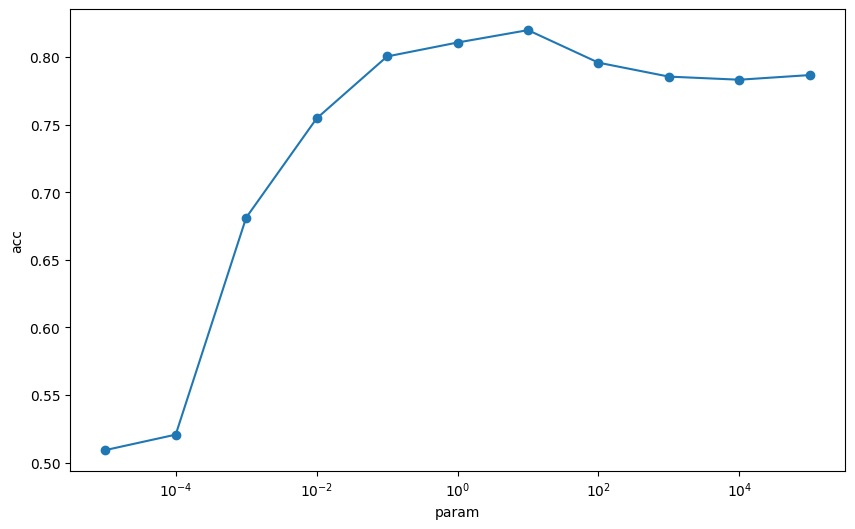

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.semilogx(cs, accs, "o-")
plt.xlabel("param")
plt.ylabel("acc")
plt.savefig("../outputs/ch07/result69.png")
plt.show()